# **8. Task Performance and Learning**

Before we move on, it is important to clarify how the systems are used in a functional context. 

## 8.1. Task Specifications

We define a task as a specific input-output mapping. Tasks can fall in one of two main categories:
* Symbolic - Both input $\mathbf{u} \in \mathbb{R}_{N_{u}\times T}$ and target output(s) $\mathbf{y} \in \mathbb{R}_{N_{y}\times T}$ are defined in discrete time ($t \in \mathbb{Z}$), as symbols from a given (finite) alphabet $\mathcal{A}$ (see [function_models](./function_models.ipynb)). If the system operates in continuous time, its states have to be *observed* at discrete sampling times, see alternatives in [state_sampling](./state_sampling.ipynb)

* Analog - Inputs $\mathbf{u}(t) \in \mathbb{R}_{N_{u}\times 1}$ and target output(s) $\mathbf{y}(t) \in \mathbb{R}_{N_{y}\times 1}$ are continuous time-varying analog values 

## 8.2. Input-driven dynamics

This framework is designed to study the functional properties of various dynamical systems (both in autonomous and input-forced conditions). In generic terms, the systems' $N$-dimensional internal states are given by:

$$\mathbf{x}(t) = F(\mathbf{W}^{\mathrm{rec}}\mathbf{x}, \mathbf{W}^{\mathrm{in}}\mathbf{u}, \dots)$$

where $F(.)$ is a suitable nonlinear operator, which can vary drammatically as we explore systems with very diverse properties. $\mathbf{W}^{\mathrm{rec}} \in \mathbb{R}_{N\times N}$ are the recurrent connection weights (which can be arbitrarily structured) and $\mathbf{W}^{\mathrm{in}} \in \mathbb{R}_{N_{u}\times N}$ the input projections. The system state may depend on additional variables, such as unit biases $\mathbf{b}$. 

Task-relevant network outputs $\mathbf{z}(t)$ are then produced by: 

$$\mathbf{z}(t) = G(\mathbf{W}^{\mathrm{out}}\mathbf{x}(t), \dots)$$

where $G(.)$ is a suitable nonlinear function that can, for example, normalize the outputs (*softmax*), take the maximum (*hardmax*), the *sign*, or simply constrain the output range (*tanh*), among others. $\mathbf{W}^{\mathrm{out}} \in \mathbb{R}_{N\times N_{y}}$ is a set of output weights that combine the population activity to produce the output. The network's outputs may also depend on additional parameters, such as output biases.

The current implementation allows us to compare a large variety of architectures, from the most commonly used `ArtificialNeuralNetworks` (implemented in `TensorFlow`), through `ContinuousRateNetworks` or `ReservoirRecurrentNetworks` (implemented in `TensorFlow` or `Python`, respectively) to complex `SpikingNeuralNetworks` (circuits of spiking neurons) and `BiophysicalSpikingNetworks` (cortical models), all implemented in `NEST`.

## 8.3. Supervised optimization problems

Solving a task amounts to finding an optimal set of parameters $\theta$ that minimize a (regularized) training error:

$$E_{\theta} = \langle \mathcal{L}(\mathbf{y}, \mathbf{z}) + R_{\theta}\rangle_{T}$$

The definition of the **loss function** and **regularization** penalties determines the error and specifies different learning algorithms. The most commonly used loss function is the quadratic error. Regularization, on the other hand, is tyically applied to scale the magnitude of the coefficients or some relevant parameters. Typically, we use the L2-norm as a regularization penalty, weighted by a fixed hyperparameter that determines the magnitude of each regularization term. Model hyperparameters are usually found by cross-validation on a representative data batch. See [decoders](./decoding.ipynb) for more information on different learning algorithms.

## 8.4. System optimization

If the system's state variable $\mathbf{x}$ and the error function $E$ are continuously differentiable, the error gradient can be back-propagated throughout the system to adjust any relevant set of parameters. 

$\theta = \{ \mathbf{W}^{\mathrm{rec}}, \mathbf{W}^{\mathrm{in}}, \mathbf{W}^{\mathrm{out}}, \mathbf{b}^{\mathrm{rec}}, \dots\}$

### 8.4.1. Supervised  

$\Delta \theta = \frac{\partial E}{\partial \theta}=\frac{\partial E}{\partial y_{i}} \frac{\partial y_{i}}{\partial a_{i}} \frac{\partial a_{i}}{\partial W_{i j}}$

### 8.4.2. Self-supervised

### 8.4.3. Unsupervised and reward-modulated


## 8.5. Decoder optimization

If $\theta=\{\mathbf{W}^{\mathrm{out}}\}$, the problem becomes much simpler. In addition, when considering the quadratic loss function, we can derive an analytical solution to the least-squares problem...

Multi-tasking.. 

By decoupling the decoder from the network, we consider it a passive measurement device, assessing how well can the network dynamics be used to solve a given computational problem (i.e. map the input to appropriate sub-spaces that allow the proper mapping to the target to be established). This also allows us to employ a large battery of parallel decoders, that can combine the network activity in different ways to compute multiple target functions, i.e. for a given input timeseries, we can consider multiple target outputs:

$\mathbf{y}_{i} = f_{i}(\mathbf{u}(t))$

Accordingly, each mapping will have a dedicated decoder, whose goal is to find the coefficients that minimize the error:

$E_{\theta}(\mathbf{y}_{i}, \mathbf{z}_{i})$, with $\mathbf{z}_{i} = g_{i}(\mathbf{W}_{i}^{\mathrm{out}} \mathbf{x}(\mathbf{u}))$

We can thus test if a given network realization can provide a rich enough set of input-driven dynamical responses that allow multiple tasks to be solved in parallel. These tasks are all functions of the same input and the solutions use the same population states.


This framework is designed to make extensive use of this feature. Note that, *internal* training (when the parameters to update include system-intrinsic parameters) can only be done for a single input-output mapping. By default, in these situations, we simply use the identity as the default internal mapping, i.e. $\mathbf{y} = \mathbf{u}$. 

### 8.6. Preparing data batches

Depending on the network type, the input and target batches will have different formats. However, they must always be a dictionary with the following structure:

```python
{'inputs': [], 'outputs': [], 'decoder_outputs': []}
```

Which has specific forms, depending on the architecture (for legacy reasons):

* `ArtificialNeuralNetwork`:
```python
data_batch = {'inputs': list(input_1, input_batch_2, ..., input_batch_n), 'targets': list(target_1, target_2, ..., target_n)}
```
with $batch_{i} \in \mathbb{R}_{T, N_{u}}$ for $i=[1, ..., N_{batches}]$, where $T$ is the batch size. 

* `ContinuousRateNetwork` and `ReservoirRecurrentNetwork`:

```python
data_batch = {'inputs': input_batch, 'targets': target_batch}
```
with $batch \in \mathbb{R}_{T, N_{batches}, N_{u}}$ for $i=[1, ..., N_{batches}]$, where $T$ is the batch time. 


* `SpikingNeuralNetwork`:

```python
data_batch = {'inputs': list(input_1, input_2, ..., input_n), 'decoder_outputs': list(target_1, target_2, ..., target_n)}
```
where each input batch in the list of $N_{batches}$ can be a sequence of symbols ($\mathbf{u} \in \mathcal{A}_{T}$) or a continuous analog signal ($\mathbf{u} \in \mathbb{R}_{N_{u}\times T}$), provided the targets are defined on the same format, i.e. $\mathbf{y}=f(\mathbf{u})$. Each `decoder_output` in the list of $N_{batches}$ is a dictionary abiding to the structure described in [decoding](decoding.ipynb), which is the same structure for all systems. 

Additionally, in the first 2 cases, the data batch dict should also contain a list of `input_times` to mark stimulus transitions (for sampling the state-space) and/or the continuous time axis within each trial / batch.

---

Naturally, each task will require specific sets of inputs and targets, which have to comply with these formats. Below we provide an example of a data set used for a MNIST sequence classification task.

In [13]:
import numpy as np
from tqdm import tqdm

from fna.tasks.symbolic import SymbolicSequencer
from fna.tasks.symbolic.embeddings import VectorEmbeddings
from fna.tasks.preprocessing import ImageFrontend

resolution = 1.
n_epochs = 10
n_batches = 2
batch_size = 50
continuous = True # only SNNs support non-continuous data (generated online)

# discrete sequencers
sequencer = SymbolicSequencer(label='random sequence', set_size=3)
image_mnist = ImageFrontend(path='../data/mnist/', label='mnist', vocabulary=sequencer.tokens)

# continuous sequencers
signal_pars = {
    'duration': 20., # [ms]
    'amplitude': 1., # [max. rate]
    'kernel': ('alpha', {'tau': 25.}),# (kernel, {kernel_pars})
    'dt': resolution # [ms]
}
image_mnist.unfold(to_signal=True, **signal_pars)

batch_time = (signal_pars['duration'] * batch_size) / resolution
inputs = np.empty(shape=(int(batch_time), int(n_batches), int(image_mnist.dimensions)), dtype=np.float32)
targets = np.empty(shape=(int(batch_time), int(n_batches), int(len(sequencer.tokens))), dtype=np.float32)

decoder_targets = []
decoder_output_pars = {'max_memory': 3, 'max_chunk': 0, 'max_prediction': 0, 'chunk_memory': False, 'chunk_prediction': False}

for batch in tqdm(range(n_batches), desc="Generating batches"):
    # inputs
    batch_seq = sequencer.generate_random_sequence(T=batch_size)
    #     input_times = np.arange(len(batch_seq))
    input_batch, input_times = image_mnist.draw_stimulus_sequence(
                        batch_seq, continuous=True, unfold=True, onset_time=0., verbose=False)
    inputs[:, batch, :] = input_batch.as_array().astype(np.float32).T
    
    # decoder outputs
    target_seq = sequencer.generate_default_outputs(batch_seq, max_memory=0, max_chunk=0, max_prediction=0)[0][
                'output']  # classification target for main network output (in ANNs)
    
    batch_targets = sequencer.generate_default_outputs(batch_seq, verbose=False, **decoder_output_pars)
    decoder_targets.append(batch_targets)

    output_signal_pars = (lambda a, b: a.update(b) or a)(signal_pars, {'kernel': ('box', {}),
                                                                       'amplitude': 1.})
    out_signal = VectorEmbeddings(vocabulary=np.unique(target_seq)).one_hot().unfold(to_signal=True,
                                                                                     verbose=False,
                                                                                     **output_signal_pars)
    target_batch = out_signal.draw_stimulus_sequence(target_seq, continuous=True, verbose=False)
    targets[:, batch, :] = target_batch[0].as_array().astype(np.float32).T
    
data_batch = {'inputs': inputs, 'targets': targets, 'decoder_outputs': decoder_targets, 'input_times': input_times}

[sequences.py:91 - INFO] Generating symbolic sequencer
[preprocessing.py:89 - INFO] MNIST target directory is not empty! Loading existing data...
[preprocessing.py:54 - INFO] Concatenating dataset (original partition in train+test will be lost): 
	- T=70000
Generating batches: 100%|██████████| 2/2 [00:39<00:00, 19.97s/it]


In [15]:
data_batch['inputs'].shape, data_batch['targets'].shape

((1000, 2, 784), (1000, 2, 3))

[(0.0, 20.0, 0), (20.0, 40.0, 0), (40.0, 60.0, 0), (60.0, 80.0, 0), (80.0, 100.0, 0), (100.0, 120.0, 0), (120.0, 140.0, 0), (140.0, 160.0, 0), (160.0, 180.0, 0), (180.0, 200.0, 0), (200.0, 220.0, 0), (220.0, 240.0, 0), (240.0, 260.0, 0), (260.0, 280.0, 0), (280.0, 300.0, 0), (300.0, 320.0, 0), (320.0, 340.0, 0), (340.0, 360.0, 0), (360.0, 380.0, 0), (380.0, 400.0, 0), (400.0, 420.0, 0), (420.0, 440.0, 0), (440.0, 460.0, 0), (460.0, 480.0, 0), (480.0, 500.0, 0), (500.0, 520.0, 0), (520.0, 540.0, 0), (540.0, 560.0, 0), (560.0, 580.0, 0), (580.0, 600.0, 0), (600.0, 620.0, 0), (620.0, 640.0, 0), (640.0, 660.0, 0), (660.0, 680.0, 0), (680.0, 700.0, 0), (700.0, 720.0, 0), (720.0, 740.0, 0), (740.0, 760.0, 0), (760.0, 780.0, 0), (780.0, 800.0, 0), (800.0, 820.0, 0), (820.0, 840.0, 0), (840.0, 860.0, 0), (860.0, 880.0, 0), (880.0, 900.0, 0), (900.0, 920.0, 0), (920.0, 940.0, 0), (940.0, 960.0, 0), (960.0, 980.0, 0), (980.0, 1000.0, 0)]


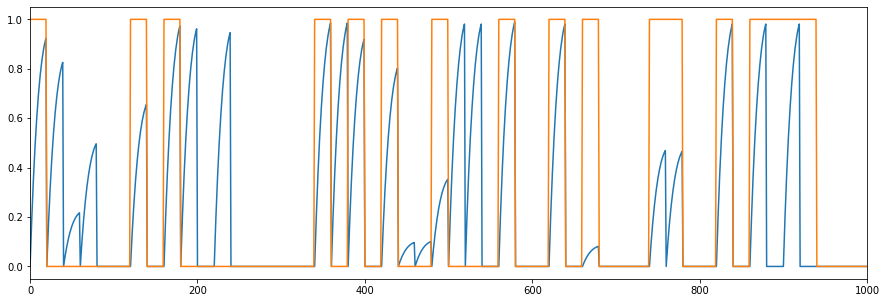

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_batch['inputs'][:, 0, 300])
ax.plot(data_batch['targets'][:, 0, 0])
ax.set_xlim([0., 1000.])
print(input_times)

In [34]:
from IPython.display import display, HTML
import pandas as pd

for t in data_batch['decoder_outputs'][0]:
    print(t['label'])
    display(HTML(pd.DataFrame({'ouput': t['output'], 'Accept': t['accept']}).transpose().to_html(header=False)))


classification


ouput,0,2,2,2,1,2,0,2,0,2,2,1,1,2,1,1,2,0,2,0,1,0,1,2,0,2,2,2,0,1,2,0,2,0,1,1,1,0,0,2,2,0,1,0,0,0,0,2,1,1
Accept,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


1-step memory


ouput,None,0,2,2,2,1,2,0,2,0,2,2,1,1,2,1,1,2,0,2,0,1,0,1,2,0,2,2,2,0,1,2,0,2,0,1,1,1,0,0,2,2,0,1,0,0,0,0,2,1
Accept,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


2-step memory


ouput,None,None,0,2,2,2,1,2,0,2,0,2,2,1,1,2,1,1,2,0,2,0,1,0,1,2,0,2,2,2,0,1,2,0,2,0,1,1,1,0,0,2,2,0,1,0,0,0,0,2
Accept,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


3-step memory


ouput,None,None,None,0,2,2,2,1,2,0,2,0,2,2,1,1,2,1,1,2,0,2,0,1,0,1,2,0,2,2,2,0,1,2,0,2,0,1,1,1,0,0,2,2,0,1,0,0,0,0
Accept,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
